# Import all units
10/12/18

this noteobok is going to continue off of 07-Data_merging and will be extracting and annotating all of the units of each value and checking for distribution (to ensure all like values on same units).

- Goal: need to Finish extracting and annotating all unit values for each datatype for all of my clinical variables.
 - Will start over and put all scripts for this into 06.3-Unit_importing.ipynb.
 - EVENTUALLY NEED TO MERGE THIS INTO THE 03_CLINICAL_VARIABLE_Final



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime
%reload_ext autotime

In [2]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 91.9 ms


In [119]:
#adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
import psycopg2
import getpass
conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 1.99 s


In [113]:
#reading in all of my data that is not limited to 72 hour time window between t_0 and t+72
date= '27082018' 

ventcategory_df=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_ventcategory_df.csv' %(date)), index_col=0)

vaso_dose_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vaso_dose_72.csv' %(date)), index_col=0)


echodata_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_echodata_72.csv' %(date)), index_col=0)
labs_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_labs_all_nosummary_72.csv' %(date)), index_col=0)


weightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_weightfirstday_df.csv' %(date)), index_col=0)
heightfirstday_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_heightfirstday_df.csv' %(date)), index_col=0)

vitals_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vitals_all_nosummary_72.csv' %(date)), index_col=0)
uti_all_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_uti_all_72.csv' %(date)), index_col=0)
bg_all_nosummary_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_bg_all_nosummary_72.csv' %(date)), index_col=0)

rrt_merged_allpt_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_rrt_merged_allpt_df.csv' %(date)), index_col=0)
gcs72_df=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_gcs72_df.csv' %(date)), index_col=0)

sofa_df_72=pd.read_csv(Path(
    wd+'/data/raw/csv/%s_sofa_df_72.csv' %(date)), index_col=0)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 17.1 s


In [114]:
def df_subset(df):
    try:
        df = df.loc[df.loc[:,'icustay_id'].isin(icustay_id),:]
    except KeyError or NameError:
        try:
            df = df.loc[df.loc[:,'hadm_id'].isin(hadm_id),:]
        except KeyError or NameError:
            df = df.loc[df.loc[:,'subject_id'].isin(patients),:]
    return(df)

time: 8.27 ms


In [115]:
# subsetting each dataframe to only patients in final_patients_df2_v:
dataframe_list= [
    ventcategory_df, vaso_dose_72, echodata_72,
    labs_all_nosummary_72, weightfirstday_df,
    heightfirstday_df, vitals_all_nosummary_72,
    uti_all_72, bg_all_nosummary_72,
    rrt_merged_allpt_df, gcs72_df, sofa_df_72
]

(
ventcategory_df, vaso_dose_72, echodata_72,
labs_all_nosummary_72, weightfirstday_df,
heightfirstday_df, vitals_all_nosummary_72,
uti_all_72, bg_all_nosummary_72,
rrt_merged_allpt_df, gcs72_df, sofa_df_72
) = (df_subset(df) for df in dataframe_list)

time: 1.26 s


In [7]:
#testing cv, mv, or both for each patient

cv_mv=pd.read_csv(Path(wd+'/data/raw/csv/12102018_ABrx_16sterile_ntnul_pts.csv'), index_col=0)

time: 34.6 ms


In [8]:
cv_mv.loc[cv_mv.loc[:,'subject_id'].isin(patients),'pt_ab_db'].value_counts() 

mv_ab              6090
cv_ab              5653
cv/mv_ab            619
both_marking_ab      41
Name: pt_ab_db, dtype: int64

time: 9.01 ms


10/5/18
# Standardizing Columns in df to merge together
### list of columns in master df:
- subject_id
- hadm_id
- icustay_id
- charttime: starttime/charttime.
- endtime: going to be null for any value listed with only a charttime. 
- label
- value
- units?
- t_0
- XdeltaX
- XdaysX
- XfrequencyX
- dtype

In [164]:
vaso_dose_72=pd.read_csv(Path(
    wd+'/data/raw/csv/72_hr_window/%s_vaso_dose_72.csv' %(date)), index_col=0)


time: 562 ms


### Vaso_dose

In [168]:
#vaso_dose_72.head()
vaso_dose_72= vaso_dose_72.rename(
    columns={'starttime':'charttime','label':'vaso_type'}
        )#.drop(labels='endtime', axis=1) 
#renaming starttime to charttime and dropping endtime

#vaso_dose_72['uom']= 'mg'

time: 31.6 ms


In [165]:
vaso_dose_72

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,label,t_0,delta
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,mg,mcg/kg/min,epinephrine,2139-06-02,0 days 16:31:00.000000000
92,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601,mg,mcg/kg/min,epinephrine,2139-09-23,0 days 15:07:00.000000000
93,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 12:00:00.000000000
94,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,2.000000,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 21:59:00.000000000
106,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,7.990853,mg,mcg/kg/min,norepinephrine,2139-09-23,0 days 23:12:00.000000000
107,200952.0,2139-09-24 21:54:00,2139-09-25 13:17:00,0.201337,7.325205,mg,mcg/kg/min,norepinephrine,2139-09-23,1 days 21:54:00.000000000
108,200952.0,2139-09-25 13:17:00,2139-09-26 03:45:00,0.351255,7.958630,mg,mcg/kg/min,norepinephrine,2139-09-23,2 days 13:17:00.000000000
118,200952.0,2139-09-25 09:24:00,2139-09-26 21:27:00,4.800000,99.999663,units,units/hour,vasopressin,2139-09-23,2 days 09:24:00.000000000
122,200952.0,2139-09-23 15:06:00,2139-09-24 00:51:00,2.509001,43.660095,mg,mcg/kg/min,phenylephrine,2139-09-23,0 days 15:06:00.000000000
124,201005.0,2169-10-25 17:25:00,2169-10-25 18:00:00,0.020000,NaN,NaN,mcgkgmin,epinephrine,2169-10-25,0 days 17:25:00.000000000


time: 47.2 ms


When looking at only the units of measurement in all inputevents_cv/mv:
### DOPAMINE : 
- Cv: Mg
 - (30043,30307)Mgkgmin
- Mv: Mg
 - mcg/kg/min
 
### Epinephrine: 
- Cv: mg
 - 30044, Mcgmin
 - 30119,30309  Mcgkgmin
- Mv: mg, mcg
 - 221289: mcg/kg/min
 
### Norepinephrine:  
- Cv: mg
 - 30047: mcgmin 
 - 30120: mcgkgmin
- Mv: mg, mcg
 - 221906: mcg/kg/min
 
### Dobutamine:
- cv:mg
 - Mcgkgmin
- Mv:mg
 - 221653: mcg/kg/min
 
### Vasopressin: 
- Cv: ml, U
 - Umin
 - Uhr
- MV: units
 - units/min
 - units/hr
 
### Phenylephrine: 
- Cv: mg
 - 30127: mcgmin
 - 30128: mcgkgmin
- Mv: mg
 - 221749: mcg/kg/min


units and itemid's ssummarized above, waiting on nelsons's feedback for how to proceed. 
##### questions:
- is mcg/min a shorthand for mcg/kg/min? or are these fundamentally different? 
 - answer: yes but mimic did account for this in the sql code.
- should i be worried that the amount uom is listed in mg, but the rate is in mcg (which appears to be shorthand for micrograms). 
    - answer: no, mimic accounted for this

### update from nelson:
I think the units mean what they mean, I don’t think there are any shorthands. We can double check. For example, most of the doses of Epinephrine and Norepinephrine in mcg/kg/min should fall in the range 0.05 to 0.1 (for dobutamine and dopamine more like 5 to 20). If the mcg/min value is truly that, then the range will depend on the patients weight. Say a 60kg patients range in mcg/min will be 3 to 6. Question: For each of these are the rates recorded in both units or some are mcg/kg/min and others mcg/min?

Also, for vasopressin: don’t use the units/HOUR ones. Those are doses that are NOT used for vasoactive purposes, so we should not be mixing it with this group of meds. Think of it as a completely different medication. 

### update on 12/15/18:
i've adjusted the sql code for each vaso_active medication to additionally extract the amount_uom and rate_uom. this is updated in the 03-clinical_variables_final.ipynb.

In [169]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,vaso_type,t_0,delta
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,mg,mcg/kg/min,epinephrine,2139-06-02,0 days 16:31:00.000000000
92,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601,mg,mcg/kg/min,epinephrine,2139-09-23,0 days 15:07:00.000000000
93,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 12:00:00.000000000
94,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,2.000000,mg,mcg/kg/min,epinephrine,2139-09-23,2 days 21:59:00.000000000
106,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,7.990853,mg,mcg/kg/min,norepinephrine,2139-09-23,0 days 23:12:00.000000000


time: 12.4 ms


In [170]:
vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_amount'].isna(),'vaso_type'].value_counts()/ vaso_dose_72.loc[:,'vaso_type'].value_counts()
#it looks like the vaso_amounts missingness is roughly porportional to the total number. 
#ie not a large bias towards some vasodilators having more missing vaso_amount
#this looks like it could be a case for using just vaso_rate.

#also from the SQL documentation: vaso_amount for carevue is not accurate. 

norepinephrine    0.803403
phenylephrine     0.777018
dopamine          0.873960
vasopressin       0.872309
epinephrine       0.833494
dobutamine        0.883736
Name: vaso_type, dtype: float64

time: 55.3 ms


In [ ]:
#task 1: lets look at the vaso_rate distributions. 

In [36]:
vaso_dose_72.groupby('vaso_type')['vaso_rate'].describe()

##vasoactive medication, not necessarily vasodilator.  normal ranges:
#dop: 0-40 ug/kg/min
#dobu: 0-40 ug/kg/min
#epi: 0-~5 ug/kg/min
#nor:0-~5 ug/kg/min
#phenyl: 0-~10 ug/kg/min
#vaso: 0-~10 units/kg/min (can be used for other types of patients w/ diabetes insipidus)


,count,mean,std,min,25%,50%,75%,max
vaso_type,,,,,,,,
dobutamine,947.0,5.125060,4.055376,0.249004,2.500000,4.000000,6.300000,25.000000
dopamine,5093.0,7.355780,9.209863,0.244873,3.333333,5.250000,10.000000,523.784242
epinephrine,1179.0,0.092613,0.573252,0.002000,0.020000,0.036613,0.085357,19.244444
norepinephrine,24115.0,0.173934,0.609784,0.000113,0.050000,0.100000,0.203860,61.439027
phenylephrine,16578.0,1.650212,4.261559,0.010000,0.500000,1.000000,2.000000,420.168221
vasopressin,1810.0,1.806855,10.219186,0.000267,0.040000,2.000000,2.400000,428.571426


time: 80.3 ms


each of the vaso_dilators have a very large maximum value 
that is many standard deviations above the mean. I need to investigate this

In [53]:
#finding the outlier
dopa_outlier1= vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_rate']==523.7842421053,:] 
dopa_outlier1

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,label,t_0,delta
69993,274503.0,2181-12-14 16:12:00,2181-12-14 22:02:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000


time: 12 ms


In [46]:
#looking at all values from the outlier
vaso_dose_72.loc[vaso_dose_72.loc[:,'icustay_id']==274503.0,:] 

,icustay_id,charttime,vaso_rate,vaso_amount,vaso_type,t_0,delta
69986,274503.0,2181-12-14 16:12:00,0.986466,7.999642,norepinephrine,2181-12-13,1 days 16:12:00.000000000
69987,274503.0,2181-12-14 22:21:00,0.493142,1.827091,norepinephrine,2181-12-13,1 days 22:21:00.000000000
69989,274503.0,2181-12-13 10:02:00,9.967099,400.000027,dopamine,2181-12-13,0 days 10:02:00.000000000
69990,274503.0,2181-12-13 17:18:00,9.966993,393.120509,dopamine,2181-12-13,0 days 17:18:00.000000000
69991,274503.0,2181-12-14 01:50:00,7.980863,400.320080,dopamine,2181-12-13,1 days 01:50:00.000000000
69992,274503.0,2181-12-14 10:38:00,11.961724,161.451978,dopamine,2181-12-13,1 days 10:38:00.000000000
69993,274503.0,2181-12-14 16:12:00,523.784242,400.000315,dopamine,2181-12-13,1 days 16:12:00.000000000
69994,274503.0,2181-12-14 22:02:00,20.210527,88.320005,dopamine,2181-12-13,1 days 22:02:00.000000000
69995,274503.0,2181-12-14 22:48:00,20.208422,23.037601,dopamine,2181-12-13,1 days 22:48:00.000000000
69996,274503.0,2181-12-14 22:47:00,3.007519,3.714286,phenylephrine,2181-12-13,1 days 22:47:00.000000000


time: 13.8 ms


In [48]:
final_pt_df2.loc[final_pt_df2.loc[:,'icustay_id']==274503.0,:] 
#patient is a C_pos/A_full, makes sense why they may have had a high rate of vaso_rate

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
3692,49613,274503.0,120323,2181-12-12 00:00:00,2181-12-15 00:00:00,full,2181-12-13,2181-12-15,2181-12-12 18:40:21,NaN,NaN,NaN,GRAM POSITIVE BACTERIA,URINE,positive,C_pos/A_full


time: 16.5 ms


[Text(0,0,'epinephrine'),
 Text(0,0,'norepinephrine'),
 Text(0,0,'vasopressin'),
 Text(0,0,'phenylephrine'),
 Text(0,0,'dopamine'),
 Text(0,0,'dobutamine')]

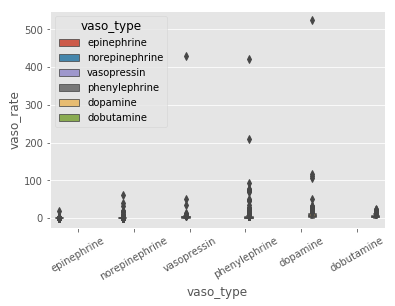

time: 349 ms


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
g= sns.boxplot(x="vaso_type", y="vaso_rate", hue="vaso_type", data=vaso_dose_72)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


## UOM data distribution 12/15/18:
the uom was recently added (after the above distribution analysis) to the sql code and now I wanan see the distribution of variables between the different uom's  and if difference between cv vs mv.

In [172]:
vaso_dose_72.groupby('vaso_type')['rate_uom'].value_counts()

vaso_type       rate_uom  
dobutamine      mcgkgmin       1391
                mcg/kg/min      183
dopamine        mcgkgmin       5041
                mcg/kg/min      727
epinephrine     mcgkgmin       1732
                mcg/kg/min      346
norepinephrine  mcgkgmin      19125
                mcg/kg/min     4680
phenylephrine   mcgkgmin      12388
                mcg/kg/min     3555
vasopressin     Umin           3924
                units/hour      605
                Uhr             209
Name: rate_uom, dtype: int64

time: 13.3 ms


according to nelson: Most of the doses of Epinephrine and Norepinephrine in mcg/kg/min should fall in the range 0.05 to 0.1 
(for dobutamine and dopamine more like 5 to 20). If the mcg/min value is truly that, then the range will depend on the patients weight. 
Say a 60kg patients range in mcg/min will be 3 to 6. 



In [195]:
#epinephrine
##grouping by the different uom's (mcg/kg/min = mv, mcgkgmin = cv)
(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='epinephrine',['vaso_amount','vaso_rate','rate_uom','amount_uom']]
     .groupby('rate_uom')
         .describe(percentiles=[.25, .5, .75,.95, .99])
             .T)


rate_uom           mcg/kg/min     mcgkgmin
vaso_amount count  346.000000     0.000000
            mean     2.283686          NaN
            std      2.279502          NaN
            min      0.007578          NaN
            25%      0.964909          NaN
            50%      1.938800          NaN
            75%      2.000000          NaN
            95%      7.999674          NaN
            99%      8.000098          NaN
            max     10.227201          NaN
vaso_rate   count  346.000000  1732.000000
            mean     0.161633     0.055967
            std      1.040042     0.110696
            min      0.009934     0.004000
            25%      0.030021     0.020000
            50%      0.060428     0.030000
            75%      0.137081     0.050000
            95%      0.342195     0.150000
            99%      0.570306     0.700000
            max     19.244444     1.000325

time: 36.3 ms


In [198]:
#looking at the largest values
(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='epinephrine',['vaso_amount','vaso_rate','rate_uom','amount_uom']]
     .groupby('rate_uom')
         .sort_values())

AttributeError: Cannot access callable attribute 'sort_values' of 'DataFrameGroupBy' objects, try using the 'apply' method

time: 17 ms


In [ ]:
##grouping by the different uom's (mcg/kg/min = mv, mcgkgmin = cv)
(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='epinephrine',['vaso_amount','vaso_rate','rate_uom','amount_uom']]
     .groupby('rate_uom')
         .describe()
             .T)

#DataFrame.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

In [203]:
(vaso_dose_72.loc[
    (vaso_dose_72.loc[:,'vaso_type']=='epinephrine')& (vaso_dose_72.loc[:,'rate_uom']=='mcg/kg/min') ,:]
         .sort_values('vaso_rate', ascending=False))

,icustay_id,charttime,endtime,vaso_rate,vaso_amount,amount_uom,rate_uom,vaso_type,t_0,delta
2105,213259.0,2168-10-02 05:35:00,2168-10-02 09:31:00,19.244444,8.000304,mg,mcg/kg/min,epinephrine,2168-10-02,0 days 05:35:00.000000000
7417,248121.0,2112-07-08 18:00:00,2112-07-09 17:14:00,2.028875,7.046363,mg,mcg/kg/min,epinephrine,2112-07-06,2 days 18:00:00.000000000
2106,213259.0,2168-10-02 09:32:00,2168-10-02 15:23:00,1.106280,8.000082,mg,mcg/kg/min,epinephrine,2168-10-02,0 days 09:32:00.000000000
3753,224474.0,2177-04-25 10:54:00,2177-04-25 12:58:00,0.623947,8.000001,mg,mcg/kg/min,epinephrine,2177-04-24,1 days 10:54:00.000000000
2590,216709.0,2178-01-29 15:16:00,2178-01-29 18:22:00,0.504745,1.561539,mg,mcg/kg/min,epinephrine,2178-01-29,0 days 15:16:00.000000000
9237,261568.0,2134-08-18 03:41:00,2134-08-18 21:15:00,0.502117,1.776282,mg,mcg/kg/min,epinephrine,2134-08-18,0 days 03:41:00.000000000
2595,217082.0,2121-06-11 18:36:00,2121-06-11 20:09:00,0.444444,1.999742,mg,mcg/kg/min,epinephrine,2121-06-11,0 days 18:36:00.000000000
6368,240507.0,2172-06-26 15:22:00,2172-06-26 15:56:00,0.408977,1.789600,mg,mcg/kg/min,epinephrine,2172-06-26,0 days 15:22:00.000000000
6367,240507.0,2172-06-26 14:53:00,2172-06-26 15:22:00,0.408970,1.526400,mg,mcg/kg/min,epinephrine,2172-06-26,0 days 14:53:00.000000000
6369,240507.0,2172-06-26 15:56:00,2172-06-26 16:00:00,0.408948,0.210526,mg,mcg/kg/min,epinephrine,2172-06-26,0 days 15:56:00.000000000


time: 46.5 ms


In [193]:
#vasopressin
##grouping by the different uom's (mcg/kg/min = mv, mcgkgmin = cv)
(vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']=='vasopressin',['vaso_amount','vaso_rate','rate_uom','amount_uom']]
     .groupby('rate_uom')
         .describe()
             .T)

#according to nelson: don’t use the units/HOUR ones. 
#Those are doses that are NOT used for vasoactive purposes, 
#so we should not be mixing it with this group of meds. 
#Think of it as a completely different medication. 

rate_uom                  Uhr         Umin  units/hour
vaso_amount count    0.000000     0.000000  605.000000
            mean          NaN          NaN   49.076043
            std           NaN          NaN   35.355632
            min           NaN          NaN    0.040008
            25%           NaN          NaN   18.440000
            50%           NaN          NaN   39.999998
            75%           NaN          NaN   86.479998
            max           NaN          NaN  199.919986
vaso_rate   count  209.000000  3924.000000  605.000000
            mean     2.555694     1.264520    3.293945
            std      0.897371     1.718483   17.391786
            min      0.400000     0.000267    0.040000
            25%      2.400000     0.040000    2.400000
            50%      2.400000     1.200000    2.400000
            75%      2.400000     2.400000    2.402884
            max      4.800000    50.000000  428.571426

time: 39.3 ms


## formatting the vaso_dose df to meet the master df standard:

In [89]:
for element in list(vaso_dose_72['vaso_type'].unique()):
    vaso_dose_72.loc[vaso_dose_72.loc[:,'vaso_type']==str(element),'vaso_type']= '%s_rate'%(element)
    
vaso_dose_72= vaso_dose_72.rename(
    columns={'vaso_type':'label','vaso_rate':'value'}).drop(labels='vaso_amount', axis=1)

AttributeError: 'dict' object has no attribute 'drop'

time: 74.6 ms


In [96]:
vaso_dose_72.head()

,icustay_id,charttime,endtime,value,label,t_0,delta,uom
4,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,epinephrine_rate_rate,2139-06-02,0 days 16:31:00.000000000,mg
108,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,epinephrine_rate_rate,2139-09-23,0 days 15:07:00.000000000,mg
109,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,epinephrine_rate_rate,2139-09-23,2 days 12:00:00.000000000,mg
110,200952.0,2139-09-25 21:59:00,2139-09-26 07:38:00,0.060601,epinephrine_rate_rate,2139-09-23,2 days 21:59:00.000000000,mg
122,200952.0,2139-09-23 23:12:00,2139-09-24 21:54:00,0.149992,norepinephrine_rate_rate,2139-09-23,0 days 23:12:00.000000000,mg


time: 12.1 ms


# labs_all_nosummary_72
- uom has been transfered to 03_clinical_variable 

In [116]:
#importing unit of mesurements:
def uom_sql_import(file_path):
    if isinstance(file_path, str)== True:
        f = open(Path(file_path), 'r')
    else:
        f = open(Path(str(file_path)), 'r')

    SQL = open(file_path,'r').read()
    SQL_df= pd.read_sql_query(SQL,conn)   
    return(SQL_df)

time: 6.87 ms


In [120]:
lab_uom= uom_sql_import(Path(wd+'/data/raw/clinical_var_sql/unit_of_mesurement/labs_uom.sql'))
labs_all_nosummary_72 = pd.merge(labs_all_nosummary_72, lab_uom, left_on='label', right_on='label')

time: 22.3 s


In [ ]:
lab_uom.loc[lab_uom.loc[:,'uom'].notnull(),:]

In [ ]:
#labs_all_nosummary_72 = pd.merge(labs_all_nosummary_72, lab_uom, left_on='label', right_on='label')

In [15]:
del(lab_uom)

time: 1.65 ms


In [16]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,t_0,delta,uom
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L


time: 13.7 ms


## formatting the labs_all_nosummary_72 df to meet the master df standard:


In [121]:
labs_all_nosummary_72['endtime']= np.nan #adding in null endtimes

time: 4.54 ms


In [122]:
labs_all_nosummary_72= labs_all_nosummary_72.rename(
    columns={'valuenum':'value'}) #changing valuenum to value

time: 610 ms


In [123]:
#missing days, may or may not keep this

time: 621 µs


In [124]:
labs_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,value,t_0,delta,uom,endtime
0,9,150750,220597,2149-11-14 07:47:00,SODIUM,137.0,2149-11-13,1 days 07:47:00.000000000,mEq/L,NaN
1,9,150750,220597,2149-11-13 03:20:00,SODIUM,130.0,2149-11-13,0 days 03:20:00.000000000,mEq/L,NaN
2,9,150750,220597,2149-11-13 16:04:00,SODIUM,129.0,2149-11-13,0 days 16:04:00.000000000,mEq/L,NaN
3,9,150750,220597,2149-11-13 19:30:00,SODIUM,131.0,2149-11-13,0 days 19:30:00.000000000,mEq/L,NaN
4,9,150750,220597,2149-11-14 01:48:00,SODIUM,133.0,2149-11-13,1 days 01:48:00.000000000,mEq/L,NaN


time: 14.9 ms


In [125]:
#ensure all uom are consistant:

labs_all_nosummary_72.groupby('label')['uom'].value_counts()

label        uom    
ALBUMIN      g/dL       10756
ANION GAP    mEq/L      61650
BANDS        %           3516
BICARBONATE  mEq/L      62606
BILIRUBIN    mg/dL      17814
BUN          mg/dL      63051
CHLORIDE     mEq/L      68812
CREATININE   mg/dL      63315
GLUCOSE      mg/dL      81925
HEMATOCRIT   %          78508
HEMOGLOBIN   g/dL       64940
LACTATE      mmol/L     34490
PLATELET     K/uL       58060
POTASSIUM    mEq/L      86455
PT           SECONDS    39677
PTT          sec        41760
SODIUM       mEq/L      71894
WBC          K/uL       56390
Name: uom, dtype: int64

time: 236 ms


# ventcategory_df_melt
has been transfered to 03_clinical_variables

In [161]:
# ventcategory_df_melt['uom']='category'
# ventcategory_df_melt['frequency']= 'once_per_day'
# ventcategory_df_melt['dtype']= 'factor'
# ventcategory_df_melt['endtime']=np.NaN
# ventcategory_df_melt['charttime']=np.NaN
# ventcategory_df_melt['days']=np.NaN
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day1','days']=1
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day2','days']=2
# ventcategory_df_melt.loc[ventcategory_df_melt.loc[:,'label']=='vent_day3','days']=3

time: 35.4 ms


In [23]:
ventcategory_df['uom']='category'
ventcategory_df['dtype']= 'factor'
ventcategory_df.head()

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,icustay_id,t_0,vent_day1,vent_day2,vent_day3,uom,dtype
0,267059.0,2182-11-12,Mech,None,None,category,factor
1,278729.0,2159-11-08,Oxygen,Mech,None,category,factor
2,219670.0,2190-08-01,Oxygen,None,None,category,factor
3,295185.0,2154-11-11,Oxygen,None,None,category,factor
4,211472.0,2193-12-11,None,None,None,category,factor


time: 66.1 ms


# weightfirstday_df_melt
has been transfered to 03_clinical_variables

In [166]:
# weightfirstday_df_melt= pd.melt(weightfirstday_df, id_vars='icustay_id', var_name='label')
# weightfirstday_df_melt.head()

,icustay_id,label,value
0,200012,weight,51.2
1,200014,weight,62.0
2,200019,weight,65.0
3,200030,weight,113.6
4,200033,weight,74.0


time: 15 ms


In [ ]:
weightfirstday_df['uom']='kg'

In [68]:
### exploring weight_durations. some were missing in both
weight_durations= uom_sql_import('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/weightdurations.sql')
import datetime

weight_durations= weight_durations.loc[weight_durations.loc[:,'icustay_id'].isin(icustay_id),:]
weight_durations= weight_durations.loc[weight_durations.loc[:,'starttime'].notnull(),:]


weight_durations['floor_starttime'] =pd.to_datetime(weight_durations['starttime']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, 24*(dt.hour//24))) 
weight_durations['floor_endtime'] =pd.to_datetime(weight_durations['endtime']).apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, 24*(dt.hour//24))) 
weight_durations= pd.merge(weight_durations, final_pt_df2[['icustay_id','t_0']])

time: 868 ms


In [74]:
#limiting durations to t_0 and t_72
weight_durations_72= weight_durations.loc[
    (weight_durations['floor_starttime'].between(
        pd.to_datetime(weight_durations['t_0']),
        (pd.to_datetime(weight_durations['t_0'])+ pd.to_timedelta(2, unit='d'))
    )),:] 


time: 73.7 ms


In [92]:
#weight durations has 371 icustay id's not available in weightfirstday for some reason, but weightfirstday has ~6000 that duration's doesn't have. idk what to do. for now i'll use first_day

#weight_durations_72['icustay_id'].nunique() #7373
#weightfirstday_df.loc[weightfirstday_df.loc[:,'weight'].notnull(),'icustay_id'].nunique() #13325

len(list(set(weight_durations_72['icustay_id'].unique()) - 
         set(weightfirstday_df.loc[weightfirstday_df.loc[:,'weight'].notnull(),'icustay_id'].unique())))


371

time: 10.1 ms


# heightfirstday_df_melt
has been transfered to 03_clinical_variables

In [95]:
heightfirstday_df['uom']='cm'

time: 433 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
heightfirstday_df.head()

,icustay_id,height,height_chart,height_echo,uom
4,216859,172.72,NaN,172.72,cm
5,203487,185.42,185.42,182.88,cm
7,254478,182.88,182.88,165.10,cm
8,296681,182.88,NaN,182.88,cm
12,211200,181.61,NaN,181.61,cm


time: 9.22 ms


# vitals_all_nosummary_nonull
- added valueuom into sql code, currently running to see if it worked. will update when finished
- works: added into 03_clinical_variables at the sql level
- need to add adjustments back into 03_clinical_variables

In [134]:
vitals_all_nosummary_72 = vitals_all_nosummary_72.rename(index=str, columns={"valueuom":"uom"}) #change valueom to uom
vitals_all_nosummary_nonull = vitals_all_nosummary_72.loc[vitals_all_nosummary_72['vitalid'].notnull(),:]#.count() #6930 NULL values
vitals_all_nosummary_nonull.head()


,subject_id,hadm_id,icustay_id,charttime,uom,vitalid,valuenum,t_0,delta
5,9,150750,220597,2149-11-13 15:20:00,mmHg,MeanArtPress,61.0,2149-11-13,0 days 15:20:00.000000000
6,9,150750,220597,2149-11-14 11:00:00,mmHg,MeanArtPress,103.0,2149-11-13,1 days 11:00:00.000000000
7,9,150750,220597,2149-11-14 12:00:00,mmHg,MeanArtPress,134.0,2149-11-13,1 days 12:00:00.000000000
12,9,150750,220597,2149-11-13 07:00:00,mmHg,MeanArtPress,85.0,2149-11-13,0 days 07:00:00.000000000
13,9,150750,220597,2149-11-14 02:00:00,mmHg,MeanArtPress,96.0,2149-11-13,1 days 02:00:00.000000000


time: 4.82 s


In [100]:
#which vital types do we have

vitals_all_nosummary_nonull['vitalid'].unique()

array(['MeanArtPress', 'SysBP', 'HeartRate', 'RespRate', 'SpO2', 'TempF',
       'Glucose', 'DiasBP', 'TempC'], dtype=object)

time: 160 ms


In [135]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #we can see here that heartrate, resprate, and tempc/f need to have their units squished

vitalid       uom     
DiasBP        mmHg        920514
Glucose       mg/dL        38548
HeartRate     bpm         526985
              BPM         427779
MeanArtPress  mmHg        933299
RespRate      insp/min    583105
              BPM         460303
SpO2          %           929932
SysBP         mmHg        920939
TempC         Deg. C       37970
              ?C           15662
TempF         ?F          104481
              Deg. F       97243
Name: uom, dtype: int64

time: 1.56 s


In [136]:
vitals_all_nosummary_nonull.loc[vitals_all_nosummary_nonull.loc[:,'uom']=='BPM','uom']='bpm'

time: 4.49 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [137]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #why does RespRate have bpm as a unit of measurement?

vitalid       uom     
DiasBP        mmHg        920514
Glucose       mg/dL        38548
HeartRate     bpm         954764
MeanArtPress  mmHg        933299
RespRate      insp/min    583105
              bpm         460303
SpO2          %           929932
SysBP         mmHg        920939
TempC         Deg. C       37970
              ?C           15662
TempF         ?F          104481
              Deg. F       97243
Name: uom, dtype: int64

time: 1.43 s


In [146]:
#lets compare the summary statistics for each uom
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='bpm'),'valuenum'].describe()

count    460303.000000
mean         20.379851
std           6.105945
min           0.170000
25%          16.000000
50%          20.000000
75%          24.000000
max          69.000000
Name: valuenum, dtype: float64

time: 981 ms


In [147]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='insp/min'),'valuenum'].describe()

count    583105.000000
mean         20.663285
std           6.055880
min           1.000000
25%          16.000000
50%          20.000000
75%          24.000000
max          69.000000
Name: valuenum, dtype: float64

time: 951 ms


In [148]:
#overall the values are extremely similar and are likely the same thing
#i will combine them.
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='RespRate') & 
    (vitals_all_nosummary_nonull['uom']=='bpm'),'uom']='insp/min'

time: 1.71 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [149]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #why does RespRate have bpm as a unit of measurement?

vitalid       uom     
DiasBP        mmHg         920514
Glucose       mg/dL         38548
HeartRate     bpm          954764
MeanArtPress  mmHg         933299
RespRate      insp/min    1043408
SpO2          %            929932
SysBP         mmHg         920939
TempC         Deg. C        37970
              ?C            15662
TempF         ?F           104481
              Deg. F        97243
Name: uom, dtype: int64

time: 1.44 s


In [150]:
#time to look at tempC and tempF

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. C'),'valuenum'].describe()

count    37970.000000
mean        37.226890
std          0.892075
min         22.000000
25%         36.700001
50%         37.299999
75%         37.799999
max         41.599998
Name: valuenum, dtype: float64

time: 892 ms


In [151]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='?C'),'valuenum'].describe()

count    15662.000000
mean        36.913786
std          1.088978
min         27.800000
25%         36.300000
50%         36.900000
75%         37.600000
max         42.000000
Name: valuenum, dtype: float64

time: 856 ms


In [152]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. F'),'valuenum'].describe()

count    97243.000000
mean        37.033567
std          0.914554
min         29.722222
25%         36.444444
50%         36.999999
75%         37.611109
max         42.777778
Name: valuenum, dtype: float64

time: 839 ms


In [153]:
vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='?F'),'valuenum'].describe()

count    104481.000000
mean         36.928289
std           0.839109
min          26.666667
25%          36.388889
50%          36.888889
75%          37.444444
max          41.000000
Name: valuenum, dtype: float64

time: 875 ms


In [155]:
#the name of these variables is a bit of a misnomer, it refers to the unit's the source was origionally in. all values here are in celcius.
#when we see teh mean of each group, the average is around:
#36.9137C (98.44481F) to 37.2268C (99.0084F)
#normal healthy range is: 36.5–37.5 °C (97.7–99.5 °F)

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempC') & 
    (vitals_all_nosummary_nonull['uom']=='?C'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='Deg. F'),'uom']='Deg. C'

vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF') & 
    (vitals_all_nosummary_nonull['uom']=='?F'),'uom']='Deg. C'


vitals_all_nosummary_nonull.loc[
    (vitals_all_nosummary_nonull['vitalid']=='TempF'),'vitalid']='TempC'

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


time: 6.44 s


In [156]:
vitals_all_nosummary_nonull.groupby('vitalid')['uom'].value_counts() #hurray, all vitals are now homogenous

vitalid       uom     
DiasBP        mmHg         920514
Glucose       mg/dL         38548
HeartRate     bpm          954764
MeanArtPress  mmHg         933299
RespRate      insp/min    1043408
SpO2          %            929932
SysBP         mmHg         920939
TempC         Deg. C       255356
Name: uom, dtype: int64

time: 1.45 s


# 10/12/18 stopped here, need to finish all below by homogenizing variables. also need to add these into 03_clinical_variables_final

# uti_all_72_melt_notnull
uom already exists in 03_clinical_variables

In [172]:
uti_all_72_melt= pd.melt(
    uti_all_72[['hadm_id','charttime','value','valuenum','valueuom','label','fluid']],
    id_vars=['hadm_id','charttime'], var_name='label')

uti_all_72_melt_notnull= uti_all_72_melt[uti_all_72_melt['value'].notnull()] #1320954

uti_all_72_melt_notnull= uti_all_72_melt_notnull.drop_duplicates(subset=['hadm_id','label','charttime']) #drops the duplicated rows
#n=7796 rows

time: 541 ms


In [105]:
uti_all_72.loc[uti_all_72.loc[:,'value'].notnull(),:] #has uom attached, but is irrelevant because all null

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,label,fluid,category,loinc_code,icd9_code,t_0,delta
60,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99831,2131-05-21,0 days 01:33:00.000000000
61,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99811,2131-05-21,0 days 01:33:00.000000000
62,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,41511,2131-05-21,0 days 01:33:00.000000000
63,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,4538,2131-05-21,0 days 01:33:00.000000000
64,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,99672,2131-05-21,0 days 01:33:00.000000000
65,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,496,2131-05-21,0 days 01:33:00.000000000
66,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,41401,2131-05-21,0 days 01:33:00.000000000
67,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,V4581,2131-05-21,0 days 01:33:00.000000000
68,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,4019,2131-05-21,0 days 01:33:00.000000000
69,36,122659.0,51486,2131-05-21 01:33:00,NEG,NaN,NaN,Leukocytes,Urine,Hematology,5799-2,60000,2131-05-21,0 days 01:33:00.000000000


time: 70.6 ms


In [174]:
uti_all_72_melt_notnull.head()


,hadm_id,charttime,label,value
0,122659.0,2131-05-21 01:33:00,value,NEG
24,128652.0,2108-08-29 07:50:00,value,NEG
40,129635.0,2160-11-02 08:55:00,value,NEG
48,176332.0,2118-07-15 19:00:00,value,NEG
66,139061.0,2141-09-11 09:15:00,value,MOD


time: 8.56 ms


In [175]:
uti_all_72_melt_notnull['value'].unique()

array(['NEG', 'MOD', 'TR', 'SM', 'LG', 'SMALL', ' ', 'Leukocytes',
       'Nitrite', 'Urine'], dtype=object)

time: 6.47 ms


In [176]:
uti_all_72_melt_notnull['label'].unique()

array(['value', 'label', 'fluid'], dtype=object)

time: 3.27 ms


# bg_all_nosummary_72
- added valueuom into sql code, currently in queue to run to see if it worked. will update when finished
- above sql code did work! values appear to be homogenous

In [160]:
#na values- removing all null values from value.
bg_all_nosummary_72= bg_all_nosummary_72.loc[bg_all_nosummary_72['value'].notnull(),:]
bg_all_nosummary_72 = bg_all_nosummary_72.rename(index=str, columns={'valueuom':'uom'})
bg_all_nosummary_72.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum,value,uom,unique_var,t_0,delta
82,9,150750,220597,2149-11-13 03:34:00,BASEEXCESS,NaN,-1,mEq/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
83,9,150750,220597,2149-11-13 03:34:00,CALCIUM,1.05,1.05,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
84,9,150750,220597,2149-11-13 03:34:00,LACTATE,1.80,1.8,mmol/L,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
85,9,150750,220597,2149-11-13 03:34:00,PCO2,34.00,34,mm Hg,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000
86,9,150750,220597,2149-11-13 03:34:00,PH,7.42,7.42,units,2205972149-11-13 03:34:00,2149-11-13,0 days 03:34:00.000000000


time: 645 ms


In [161]:
bg_all_nosummary_72.groupby('label')['uom'].value_counts()  #looks like all units are homogenous (ie no 2x different unit for same value)

label              uom   
AADO2              mm Hg      3518
BASEEXCESS         mEq/L     67058
BICARBONATE        mEq/L       702
CALCIUM            mmol/L    29932
CARBOXYHEMOGLOBIN  %           236
CHLORIDE           mEq/L      4735
FIO2               %         13635
GLUCOSE            mg/dL     20241
HEMATOCRIT         %          8562
HEMOGLOBIN         g/dL       8562
LACTATE            mmol/L    34503
METHEMOGLOBIN      %           232
O2FLOW             L/min      1680
PCO2               mm Hg     67062
PH                 units     70834
PO2                mm Hg     25263
POTASSIUM          mEq/L     19239
PaO2               mm Hg     41810
SO2                %         23258
SODIUM             mEq/L      6678
TOTALCO2           mEq/L     67060
Name: uom, dtype: int64

time: 184 ms


# rrt_merged_allpt_df_notnull
- added into 03_clinical_variables

In [108]:
#na values
# rrt_merged_allpt_df_notnull = rrt_merged_allpt_df.loc[rrt_merged_allpt_df['rrt'].notnull(),:]
# rrt_merged_allpt_df_notnull['uom']='category'
# rrt_merged_allpt_df_notnull
#rrt_merged_allpt_df_notnull['uom']='category'

,icustay_id,t_0,first_charttime,rrt
7,252135.0,2166-04-13,2166-04-13 00:00:00,1.0
8,293255.0,2167-10-21,2167-10-21 04:31:00,1.0
9,261279.0,2167-10-26,2167-10-26 01:00:00,1.0
20,251526.0,2129-12-20,2129-12-20 09:32:00,1.0
31,255314.0,2181-10-11,2181-10-11 01:00:00,1.0
34,254751.0,2181-12-29,2181-12-29 04:30:00,1.0
44,224516.0,2175-05-05,2175-05-06 12:21:00,1.0
85,203603.0,2145-04-16,2145-04-16 11:00:00,1.0
93,239528.0,2104-08-05,2104-08-05 00:00:00,1.0
94,262011.0,2190-01-10,2190-01-12 11:30:00,1.0


time: 21.5 ms


In [107]:
#rrt_merged_allpt_df_notnull

NameError: name 'rrt_merged_allpt_df_notnull' is not defined

time: 7.11 ms


# gcs72_df_melt_notnull
- added into 03_clinical_variables

In [ ]:
#need to reshape the dataframe
# gcs72_df_melt = pd.melt(gcs72_df, id_vars=['subject_id','hadm_id','icustay_id','t_0','ICU_admit','admit_plus_day','delta'], var_name='label')

# gcs72_df_melt_notnull= gcs72_df_melt[gcs72_df_melt['value'].notnull()] #62772 ->62650
# gcs72_df_melt_notnull.head()

In [110]:
gcs72_df['uom']='GCS_score'

time: 437 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# sofa_df_melt_notnull
- complex units, may not use variables. I will keep this as is

In [ ]:
#need to reshape the dataframe
sofa_df_melt = pd.melt(sofa_df_72, id_vars=['subject_id','hadm_id','icustay_id','t_0','day','ICU_admit','approx_charttime','floor_charttime'], var_name='label')

sofa_df_melt_notnull= sofa_df_melt[sofa_df_melt['value'].notnull()] #606651 ->302459
sofa_df_melt_notnull.head()

In [111]:
sofa_df_72 #complex units, may not use variables

,subject_id,hadm_id,icustay_id,day,sofa,respiration,pao2fio2_vent_min,pao2fio2_novent_min,coagulation,platelet_min,...,meanbp_min,cns,mingcs,renal,creatinine_max,urineoutput,t_0,ICU_admit,approx_charttime,floor_charttime
4,9,150750,220597,4.0,6,0.0,204.000000,NaN,0.0,306.0,...,54.000000,NaN,NaN,2.0,2.0,6020.0,2149-11-13,2149-11-09 13:07:02,2149-11-13 13:07:02,2149-11-13 00:00:00
5,9,150750,220597,5.0,7,NaN,NaN,NaN,NaN,NaN,...,91.000000,NaN,NaN,4.0,NaN,100.0,2149-11-13,2149-11-09 13:07:02,2149-11-14 13:07:02,2149-11-14 00:00:00
7,19,109235,273430,1.0,0,NaN,NaN,NaN,NaN,NaN,...,78.000000,NaN,NaN,0.0,NaN,780.0,2108-08-06,2108-08-05 16:26:09,2108-08-06 16:26:09,2108-08-06 00:00:00
14,21,111970,216859,6.0,8,NaN,NaN,NaN,0.0,151.0,...,42.000000,NaN,NaN,4.0,2.4,80.0,2135-02-05,2135-01-30 20:53:34,2135-02-05 20:53:34,2135-02-05 00:00:00
15,21,111970,216859,7.0,9,NaN,NaN,NaN,NaN,NaN,...,39.000000,4.0,4.0,4.0,NaN,10.0,2135-02-05,2135-01-30 20:53:34,2135-02-06 20:53:34,2135-02-06 00:00:00
16,21,111970,216859,8.0,5,NaN,NaN,NaN,NaN,NaN,...,44.000000,NaN,NaN,4.0,NaN,5.0,2135-02-05,2135-01-30 20:53:34,2135-02-07 20:53:34,2135-02-07 00:00:00
17,25,129635,203487,0.0,4,NaN,NaN,NaN,0.0,172.0,...,24.000000,NaN,NaN,1.0,1.6,3025.0,2160-11-02,2160-11-02 03:16:23,2160-11-02 03:16:23,2160-11-02 00:00:00
18,25,129635,203487,1.0,1,NaN,NaN,NaN,0.0,164.0,...,60.000000,0.0,15.0,0.0,NaN,2305.0,2160-11-02,2160-11-02 03:16:23,2160-11-03 03:16:23,2160-11-03 00:00:00
19,25,129635,203487,2.0,2,NaN,NaN,NaN,1.0,147.0,...,69.000000,NaN,NaN,0.0,0.7,2730.0,2160-11-02,2160-11-02 03:16:23,2160-11-04 03:16:23,2160-11-04 00:00:00
31,31,128652,254478,7.0,7,0.0,327.500000,NaN,0.0,260.0,...,25.000000,NaN,NaN,3.0,1.5,382.0,2108-08-29,2108-08-22 23:28:42,2108-08-29 23:28:42,2108-08-29 00:00:00


time: 114 ms


In [163]:
sofa_df_72#.groupby('label')['uom'].value_counts()

,subject_id,hadm_id,icustay_id,day,sofa,respiration,pao2fio2_vent_min,pao2fio2_novent_min,coagulation,platelet_min,...,meanbp_min,cns,mingcs,renal,creatinine_max,urineoutput,t_0,ICU_admit,approx_charttime,floor_charttime
4,9,150750,220597,4.0,6,0.0,204.000000,NaN,0.0,306.0,...,54.000000,NaN,NaN,2.0,2.0,6020.0,2149-11-13,2149-11-09 13:07:02,2149-11-13 13:07:02,2149-11-13 00:00:00
5,9,150750,220597,5.0,7,NaN,NaN,NaN,NaN,NaN,...,91.000000,NaN,NaN,4.0,NaN,100.0,2149-11-13,2149-11-09 13:07:02,2149-11-14 13:07:02,2149-11-14 00:00:00
7,19,109235,273430,1.0,0,NaN,NaN,NaN,NaN,NaN,...,78.000000,NaN,NaN,0.0,NaN,780.0,2108-08-06,2108-08-05 16:26:09,2108-08-06 16:26:09,2108-08-06 00:00:00
14,21,111970,216859,6.0,8,NaN,NaN,NaN,0.0,151.0,...,42.000000,NaN,NaN,4.0,2.4,80.0,2135-02-05,2135-01-30 20:53:34,2135-02-05 20:53:34,2135-02-05 00:00:00
15,21,111970,216859,7.0,9,NaN,NaN,NaN,NaN,NaN,...,39.000000,4.0,4.0,4.0,NaN,10.0,2135-02-05,2135-01-30 20:53:34,2135-02-06 20:53:34,2135-02-06 00:00:00
16,21,111970,216859,8.0,5,NaN,NaN,NaN,NaN,NaN,...,44.000000,NaN,NaN,4.0,NaN,5.0,2135-02-05,2135-01-30 20:53:34,2135-02-07 20:53:34,2135-02-07 00:00:00
17,25,129635,203487,0.0,4,NaN,NaN,NaN,0.0,172.0,...,24.000000,NaN,NaN,1.0,1.6,3025.0,2160-11-02,2160-11-02 03:16:23,2160-11-02 03:16:23,2160-11-02 00:00:00
18,25,129635,203487,1.0,1,NaN,NaN,NaN,0.0,164.0,...,60.000000,0.0,15.0,0.0,NaN,2305.0,2160-11-02,2160-11-02 03:16:23,2160-11-03 03:16:23,2160-11-03 00:00:00
19,25,129635,203487,2.0,2,NaN,NaN,NaN,1.0,147.0,...,69.000000,NaN,NaN,0.0,0.7,2730.0,2160-11-02,2160-11-02 03:16:23,2160-11-04 03:16:23,2160-11-04 00:00:00
31,31,128652,254478,7.0,7,0.0,327.500000,NaN,0.0,260.0,...,25.000000,NaN,NaN,3.0,1.5,382.0,2108-08-29,2108-08-22 23:28:42,2108-08-29 23:28:42,2108-08-29 00:00:00


time: 142 ms
